<a href="https://colab.research.google.com/github/ucfilho/ANN/blob/master/Cat_vs_Dog_nov_07_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os 
import cv2
import re, random
from tqdm import tqdm_notebook
from random import shuffle
import shutil


%matplotlib inline

In [0]:
#https://www.kaggle.com/sarvajna/dogs-vs-cats-keras-solution
#https://www.kaggle.com/deadskull7/cats-vs-dogs-84

In [27]:
!pip install keras-tqdm
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import itertools

import matplotlib.image as mpimg
import seaborn as sns

In [0]:
data_directory = '/tmp'
model_directory = '/afs/dogscats/run1'

if not os.path.isdir(model_directory):
    os.makedirs(model_directory)

In [0]:
def get_data(local_data_root: str, is_chief: bool=True):
    data_dir = os.path.join(local_data_root, 'datasets/dogscats')
    
    if is_chief:
        if not os.path.isdir(data_dir):
            # Download the data zip to our data directory and extract
            fallback_url = 'http://files.fast.ai/data/dogscats.zip'
            tf.keras.utils.get_file(
                os.path.join('/tmp', os.path.basename(fallback_url)), 
                fallback_url, 
                cache_dir='/tmp',
                extract=True)
        
    return data_dir

In [0]:
data_dir = get_data(data_directory, True)

In [0]:
def organize_datasets(path_to_data, n=4000, ratio=0.2):
    files = os.listdir(path_to_data)
    files = [os.path.join(path_to_data, f) for f in files]
    shuffle(files)
    files = files[:n]
    
    n = int(len(files) * ratio)
    val, train = files[:n], files[n:]
    

    shutil.rmtree('./data/')
    print('/data/ removed')

    for c in ['dogs', 'cats']: 
        os.makedirs('./data/train/{0}/'.format(c))
        os.makedirs('./data/validation/{0}/'.format(c))

    print('folders created !')

    for t in tqdm_notebook(train):
        if 'cat' in t:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'cats'))
        else:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'dogs'))
     
    for v in tqdm_notebook(val):
        if 'cat' in v:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'cats'))
        else:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'dogs'))
            
    print('Data copied!')

In [0]:
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale=1/255.)

In [33]:
os.listdir(data_dir)

['train', 'models', 'sample', 'test1', 'valid']

In [34]:
os.listdir(os.path.join(data_dir, 'valid'))

['dogs', 'cats']

In [35]:
cats = os.listdir(os.path.join(data_dir, 'valid', 'cats'))
cats

['cat.8587.jpg',
 'cat.1278.jpg',
 'cat.1721.jpg',
 'cat.11045.jpg',
 'cat.4309.jpg',
 'cat.1068.jpg',
 'cat.10485.jpg',
 'cat.3111.jpg',
 'cat.7849.jpg',
 'cat.12446.jpg',
 'cat.209.jpg',
 'cat.6445.jpg',
 'cat.2572.jpg',
 'cat.1282.jpg',
 'cat.11366.jpg',
 'cat.11142.jpg',
 'cat.2734.jpg',
 'cat.3026.jpg',
 'cat.5499.jpg',
 'cat.9856.jpg',
 'cat.8508.jpg',
 'cat.11794.jpg',
 'cat.2238.jpg',
 'cat.602.jpg',
 'cat.12061.jpg',
 'cat.9100.jpg',
 'cat.6674.jpg',
 'cat.2216.jpg',
 'cat.6701.jpg',
 'cat.7325.jpg',
 'cat.8567.jpg',
 'cat.6440.jpg',
 'cat.8175.jpg',
 'cat.4219.jpg',
 'cat.9895.jpg',
 'cat.12291.jpg',
 'cat.2302.jpg',
 'cat.7229.jpg',
 'cat.11922.jpg',
 'cat.5694.jpg',
 'cat.7979.jpg',
 'cat.7492.jpg',
 'cat.3215.jpg',
 'cat.5031.jpg',
 'cat.1547.jpg',
 'cat.2569.jpg',
 'cat.12352.jpg',
 'cat.264.jpg',
 'cat.10152.jpg',
 'cat.10968.jpg',
 'cat.9480.jpg',
 'cat.811.jpg',
 'cat.12019.jpg',
 'cat.2394.jpg',
 'cat.3142.jpg',
 'cat.10133.jpg',
 'cat.9524.jpg',
 'cat.4036.jpg',
 'ca

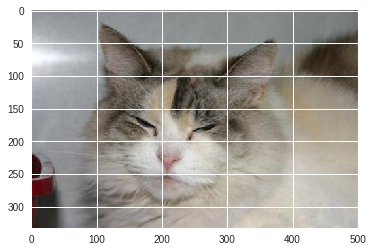

In [36]:
img = plt.imread(os.path.join(data_dir, 'valid', 'cats', cats[0]))
plt.imshow(img)

In [37]:
img.shape

(333, 500, 3)

In [38]:
dogs = os.listdir(os.path.join(data_dir, 'valid', 'dogs'))
dogs[:5]

['dog.3116.jpg',
 'dog.10018.jpg',
 'dog.9675.jpg',
 'dog.5724.jpg',
 'dog.978.jpg']

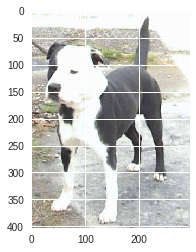

In [39]:
img = plt.imread(os.path.join(data_dir, 'valid', 'dogs', dogs[0]))
plt.imshow(img)

In [40]:
print(len(dogs))

1000


In [41]:
x = [] # images as arrays
y = [] # labels
img_width = 150
img_height = 150
k=0

for i in range(2000):
  
  if(i%2==0):
    print("dog")
    path = os.path.join(data_dir, 'valid', 'dogs', dogs[k])
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width,img_height))
    #x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
    x.append([np.array(img)])
    y.append(1)
    k=k+1


  else:
    print("cat")
    path = os.path.join(data_dir, 'valid', 'cats', cats[k])
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width,img_height))
    #x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
    x.append([np.array(img)])
    y.append(0)
    
    
print(len(y))
print(y)  
print(x)  
    

dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat
dog
cat


IndexError: ignored

In [0]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_val, Y_train, Y_val = train_test_split(x,y, test_size=0.2, random_state=1)

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [45]:
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1599, 1, 150, 150) (150 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (400, 1, 150, 150) (150 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
batch_size = 16